In [187]:


import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.patches as mpatches

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.test import load_models, generate_predictions, plot_predictions
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#77b5e5', '#e46c81', '#97d2c5', '#e696cc', '#b6b6b6', '#a980b8', '#e9d66b'])

In [188]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_small.csv')

In [189]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [190]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 135)

In [191]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(103, 132)


In [192]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 132)
(103, 132)


In [193]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [194]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()
gaussian_scaler = StandardScaler()
non_gaussian_scaler = RobustScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)


# Fit the scaler to the dataframe and transform the dataframe
Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])


In [195]:
X.shape

(103, 122)

In [196]:
corr_matrix = scaled_X.corr()

In [197]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

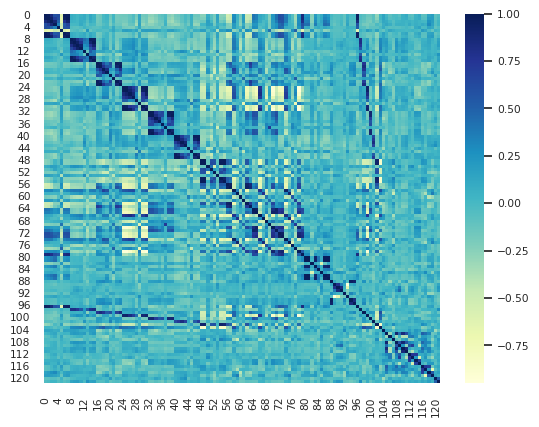

In [198]:
plot_correlation_matrix(scaled_X)

In [199]:
def get_selected_voting_features_uni(Y, X_filtered, filter_methods, k):
    np.random.seed(41) 
    
    feature_counts = np.zeros(X_filtered.shape[1])
        
    for method_name, method in filter_methods.items():
        pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
        pipeline.fit(X_filtered, Y)
        selected_i = pipeline.named_steps[method_name].get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
                
    # Get the indices of the top k features with the most counts
    top_k_features = np.argsort(feature_counts)[-k:]
    
    return top_k_features

In [200]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=10),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_uni(Y.iloc[:, i], scaled_X, filter_methods, k=10)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


P : [20 89 25 83 31 78 74 66 11 24]
E : [109  95  86  63  78  66  24  94 110  81]
R : [ 99  16  95  94  92  37  87  33 106  88]
M : [ 24  75 104  43  91 100  20  19 110 120]
A : [24 92 25 78 87 30 31 80 66  0]


In [201]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=42)

In [202]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    X_test_final = X_test.iloc[:, list(set(selected_features))]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)


P : ['Arousal__standard_deviation', 'Dominance__standard_deviation', 'Disgust__maximum', 'Dominance__P_25', 'Brightness__maximum', 'Happy__minimum', 'Sad__median', 'Velocity__mean', 'Sad__mean', 'Sad__P_75']
E : ['Arousal__standard_deviation', 'Gazes_Min', 'Dominance__P_25', 'Gazes_Max', 'Brightness__mean', 'Brightness__P_25', 'Sad__median', 'Velocity__P_25', 'Velocity__P_75', 'Valence__P_75']
R : ['Surprise__mean', 'Sad__max_count', 'Surprise__Slope', 'In-degree Centrality', 'Happy__median', 'Brightness__P_75', 'Velocity__median', 'Velocity__minimum', 'Velocity__P_25', 'Velocity__P_75']
M : ['Surprise__max_count', 'Presence', 'Fear__maximum', 'Dominance__maximum', 'Gazes_Max', 'Happy__maximum', 'Happy__minimum', 'Sad__median', 'Velocity__maximum', 'Std_X_Center']
A : ['Angry__median', 'Arousal__standard_deviation', 'Dominance__P_25', 'Brightness__median', 'Brightness__P_75', 'Sad__median', 'Sad__mean', 'Velocity__minimum', 'Sad__P_25', 'Sad__P_75']


In [203]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small")

eval_metric = "mean_absolute_error"

In [204]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR", "Lasso"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
GradientBoostingRegressor
AdaBoostRegressor
LinearRegression
Ridge
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [205]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")
    results = search.run(X_final["train"], Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/Ridge.joblib
Models for ElasticNet saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ElasticNet.joblib
Models for BayesianRidge sa

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.961e-04, tolerance: 2.351e-04
  model = cd_fast.enet_coordinate_descent(


Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/Ridge.joblib
Models for ElasticNet saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/A/ElasticNet.joblib
Models for BayesianRidge saved to /home/moritz

In [206]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim
    models = load_models(models_path)
    perma_models[perma_dim] = models

In [207]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [208]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [209]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'Ridge', 'mae': 0.14620703366963458, 'preds': array([0.67761102, 0.68240286, 0.66957583, 0.61479983, 0.72702644,
       0.67888677, 0.64289916, 0.60043934, 0.73543573, 0.71713564,
       0.53698488, 0.63158882, 0.67803791, 0.51121064, 0.71651175,
       0.71115784, 0.70670723, 0.68864957, 0.70157994, 0.60769518,
       0.70801558])}, 'E': {'model': 'CatBoostRegressor', 'mae': 0.18643050709131487, 'preds': array([0.440175  , 0.57235063, 0.46341743, 0.57074173, 0.68891564,
       0.67993456, 0.54076802, 0.61660844, 0.48179778, 0.79477046,
       0.45029151, 0.34320972, 0.61608356, 0.47680434, 0.63357131,
       0.51431625, 0.60511101, 0.39143479, 0.47200729, 0.44496072,
       0.70185952])}, 'R': {'model': 'ElasticNet', 'mae': 0.14010919774285022, 'preds': array([0.66376308, 0.78605144, 0.70326537, 0.64765262, 0.79013667,
       0.75501206, 0.74941638, 0.7939378 , 0.69347854, 0.82248612,
       0.59032514, 0.67323103, 0.7627715 , 0.60579977, 0.81216077,
       0.66383766,

In [210]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim


{'P': array([0.01168082, 0.04444899, 0.03504981, 0.1003001 , 0.02084693,
        0.00062495, 0.06560951, 0.00817637, 0.1425677 , 0.02951367]),
 'E': array([ 2.13970463,  8.07372232,  3.32008578, 16.85671828,  2.84796707,
        11.10504103,  4.19362902, 12.82770141, 11.40321595, 27.23221451]),
 'R': array([0.        , 0.01208028, 0.        , 0.        , 0.02405761,
        0.03646236, 0.01364476, 0.0305898 , 0.        , 0.03956884]),
 'M': array([0.06155413, 0.03961572, 0.1002351 , 0.10377872, 0.07904124,
        0.1811801 , 0.17388085, 0.16926572, 0.03999556, 0.05145286]),
 'A': array([0.00187355, 0.01648517, 0.09280145, 0.02570765, 0.00376088,
        0.08525167, 0.04585108, 0.03470558, 0.02898091, 0.06457723])}

In [211]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats


/tmp/ipykernel_222137/4206057206.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


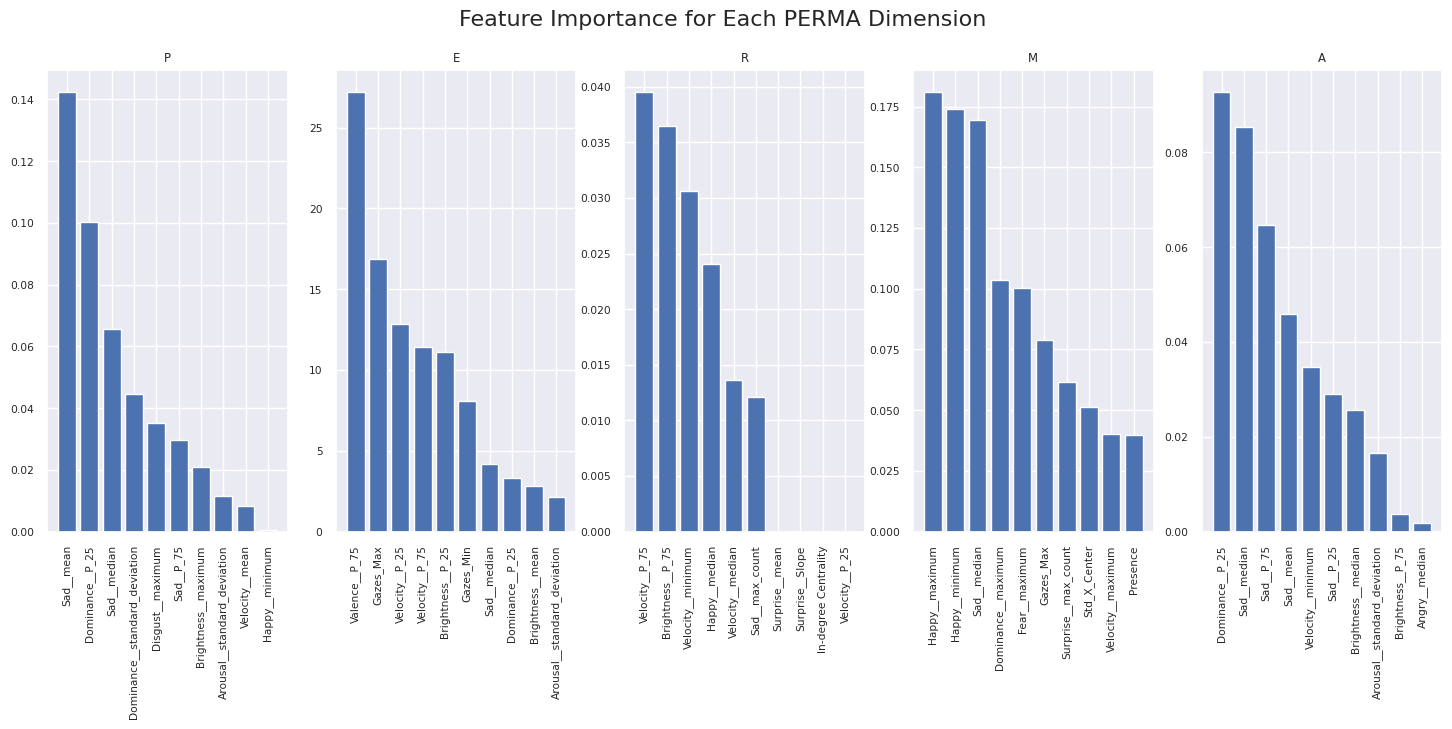

In [212]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for Each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [213]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.16439909 0.20816327 0.14739229 0.20272109 0.1462585 ]


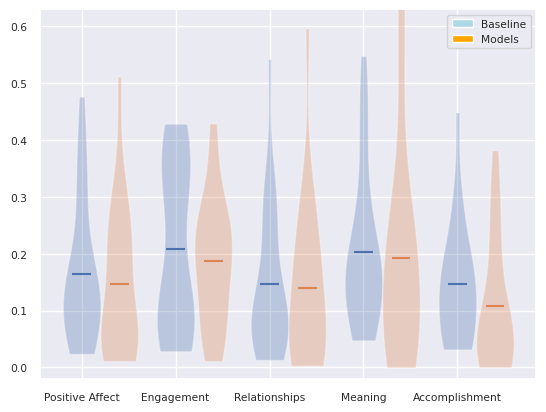

In [220]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['Positive Affect', 'Engagement', 'Relationships', 'Meaning', 'Accomplishment']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)
ax.set_ylim(-0.02, 0.63)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

Text(0.5, 1.0, 'PERMA Dimension MAE Scores')

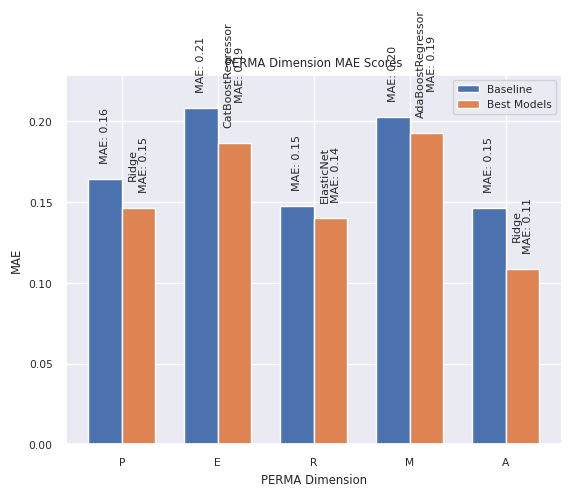

In [215]:
# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimension')

# Set the y-axis label and limits
ax.set_ylabel('MAE')
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, v+0.01, f"MAE: {v:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)
    ax.text(i+bar_width, best_mae_values[i]+0.01, f"{best_results[perma_dimensions[i]]['model']}\nMAE: {best_mae_values[i]:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)

# Add a legend and title
ax.legend()
ax.set_title('PERMA Dimension MAE Scores')

In [ ]:
Y_preds = pd.DataFrame()

for dim in ['P', 'E', 'R', 'M', 'A']:
    err = best_results[dim]['preds']
    errors = pd.DataFrame({'errors': err})
    Y_preds = pd.concat([Y_preds, errors], axis=1)

# Unscale the data back to the original scale
Y_preds = pd.DataFrame(minmax_scaler.inverse_transform(Y_preds), columns=['P', 'E', 'R', 'M', 'A'])
Y_tests = pd.DataFrame(minmax_scaler.inverse_transform(Y_test), columns=['P', 'E', 'R', 'M', 'A'])
Y_baselines = pd.DataFrame(minmax_scaler.inverse_transform(Y_baseline), columns=['P', 'E', 'R', 'M', 'A'])

Text(0.5, 1.0, 'PERMA')

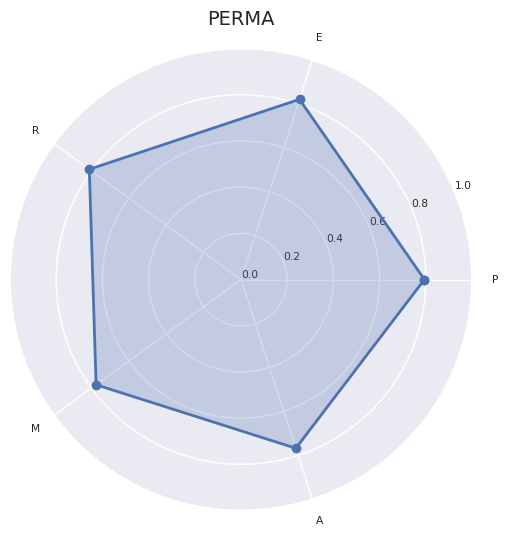

In [216]:
# Define the labels for the radar plots
labels = ['P', 'E', 'R', 'M', 'A']

# Create the figure and subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Loop over each row of Y_tests and Y_preds
for i in [np.random.randint(0, len(Y_tests))]:
    # Define the data for the radar plot
    data1 = Y_tests.iloc[i].values
    data2 = Y_preds.iloc[i].values
    #data3 = Y_baselines.iloc[i].values

    # Define the angle for each label
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    # Close the plot
    data1 = np.concatenate((data1, [data1[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    data2 = np.concatenate((data2, [data2[0]]))
    #data3 = np.concatenate((data3, [data3[0]]))

    # Plot the radar plot
    ax.plot(angles, data1, 'o-', linewidth=2, label=f'Target')
    ax.fill(angles, data1, alpha=0.25)
    ax.plot(angles, data2, 'o-', linewidth=2, label=f'Prediction')
    ax.fill(angles, data2, alpha=0.25)
    #ax.plot(angles, data3, 'o-', linewidth=2, label=f'Baseline')
    #ax.fill(angles, data3, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 7.1, 1.0))
plt.ylim(0, 7)
plt.title('Comparison of PERMA Scores', fontsize=14)
plt.legend()